In [146]:
import os
import time
import skdim
import numpy as np
import numpy as gfg
import pandas as pd
import seaborn as sns
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

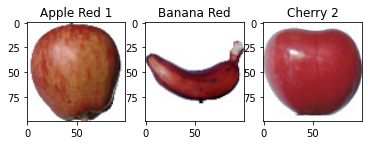

In [2]:
plt.subplot(1, 3, 1)
image1 = mpimg.imread('/Users/fionachang/Desktop/data604/final project/archive/Training/Apple Red 1/0_100.jpg')
plt.title('Apple Red 1')
plt.imshow(image1)
plt.subplot(1, 3, 2)
image2 = mpimg.imread('/Users/fionachang/Desktop/data604/final project/archive/Training/Banana Red/0_100.jpg')
plt.title('Banana Red')
plt.imshow(image2)
plt.subplot(1, 3, 3)
image3 = mpimg.imread('/Users/fionachang/Desktop/data604/final project/archive/Training/Cherry 2/1_100.jpg')
plt.title('Cherry 2')
plt.imshow(image3)
plt.show()

In [87]:
image_t = Image.open('/Users/fionachang/Desktop/data604/final project/archive/Training/Apple Red 1/0_100.jpg')
imageToMatrice = gfg.asarray(image_t)
imageToMatrice[0][0]

array([255, 253, 255], dtype=uint8)

In [3]:
#get fruit data and transfer fruit image to 1D array
def fruit_data(folder, fruit):
    path = '/Users/fionachang/Desktop/data604/final project/archive'
    path = os.path.join(path, folder, fruit)
    files = [os.path.join(path, f) for f in os.listdir(path) if 
    os.path.isfile(os.path.join(path, f))]
    imgs = []
    for file in files:
        img = Image.open(file)
        imageToMatrice = gfg.asarray(img)
        imageToMatrice = np.mean(imageToMatrice, axis=-1) #calculate mean of the rbg and turn into 100*100 matrix
        imageToMatrice = imageToMatrice.reshape(-1) #transfer 100*100 rbg matrix to 1D array
        imgs.append(imageToMatrice)
    return imgs

In [4]:
#transfer fruit data to dataframe
def fruit_df(folder1, folder2, fruit, label):
    fruit_lst1 = fruit_data(folder1, fruit)
    fruit_lst2 = fruit_data(folder2, fruit)
    length = list(str(i) for i in range(10000))
    fruit_df = pd.DataFrame()
    fruit_df = fruit_df.append(fruit_lst1)
    fruit_df = fruit_df.append(fruit_lst2)
    fruit_df['label']= label
    return fruit_df

In [5]:
apple_df = fruit_df('Training','Test', 'Apple Red 1','0').sample(frac=1)
banana_df = fruit_df('Training','Test', 'Banana Red','1').sample(frac=1)
cherry_df = fruit_df('Training','Test', 'Cherry 2','2').sample(frac=1)

In [6]:
print(apple_df.shape)
print(banana_df.shape)
print(cherry_df.shape)

(656, 10001)
(656, 10001)
(984, 10001)


In [7]:
fruits_df = pd.concat([apple_df, banana_df, cherry_df], ignore_index=True)

In [8]:
#build a function for train test split by class.
def tts_by_class(df, n): 
    train = pd.DataFrame()
    for i in range(3):
        train_oneclass = df.loc[df['label']==str(i)].iloc[:n]
        train = train.append(train_oneclass)
    test = df.loc[df.index.difference(train.index)]
    return train, test

In [9]:
def knn_20(train, test, dist='euclidean'):
    X_train = train.drop(columns=['label'])
    y_train = train['label'].copy()
    X_test = test.drop(columns=['label'])
    y_test = test['label'].copy()
    neigh = KNeighborsClassifier(n_neighbors=20, metric=dist)
    neigh.fit(X_train, y_train)
    y_pred=neigh.predict(X_test)
    return y_pred

In [10]:
cal_time = []
acc_vs_size = []
train_num = list(range(10,500,10))
for i in train_num:
    start_time = time.time()
    train_testn, test_testn = tts_by_class(fruits_df,i)
    predict_testn = knn_20(train_testn, test_testn)
    global_acc=sum(np.array(predict_testn)==np.array(test_testn['label']))/len(test_testn)
    end_time = time.time()
    acc_vs_size.append(global_acc)
    cal_time.append(end_time-start_time)

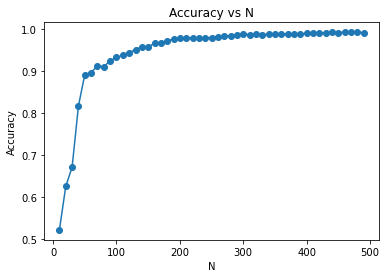

In [11]:
plt.plot(train_num, acc_vs_size,'-o')
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.title("Accuracy vs N")
plt.show()

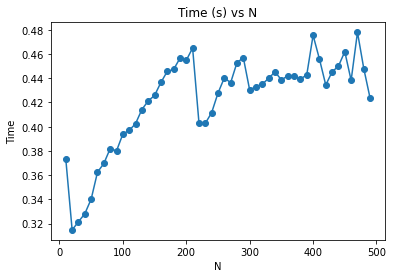

In [12]:
plt.plot(train_num, cal_time,'-o')
plt.xlabel("N")
plt.ylabel("Time")
plt.title("Time (s) vs N")
plt.show()

In [94]:
apple_train = apple_df[:300]
apple_val = apple_df[300:400]
apple_test = apple_df[400:]
banana_train = banana_df[:300]
banana_val = banana_df[300:400]
banana_test = banana_df[400:]
cherry_train = cherry_df[:300]
cherry_val = cherry_df[300:400]
cherry_test = cherry_df[400:656]

In [95]:
train_df = pd.concat([apple_train, banana_train, cherry_train], ignore_index=True).sample(frac=1)
val_df = pd.concat([apple_val, banana_val, cherry_val], ignore_index=True).sample(frac=1)
test_df = pd.concat([apple_test, banana_test, cherry_test], ignore_index=True).sample(frac=1)

In [96]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

900
300
768


In [97]:
def feature_label_split(train, val, test):
    X_train = train.copy().drop(columns=['label'])
    y_train = train['label'].copy()
    X_val = val.copy().drop(columns=['label'])
    y_val = val['label'].copy()
    X_test = test.copy().drop(columns=['label'])
    y_test = test['label'].copy()
    return X_train, y_train, X_val, y_val, X_test, y_test

In [98]:
X_train, y_train, X_val, y_val, X_test, y_test = feature_label_split(train_df, val_df, test_df)

In [99]:
def test_diff_k_acc(X_tr, y_tr, X_v, y_v):
    acc_lst = []
    for i in range(1,21):
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X_tr, y_tr)
        y_pred = neigh.predict(X_v)
        acc = sum(y_pred == y_v)/len(y_v)
        acc_lst.append(acc)    
    return acc_lst

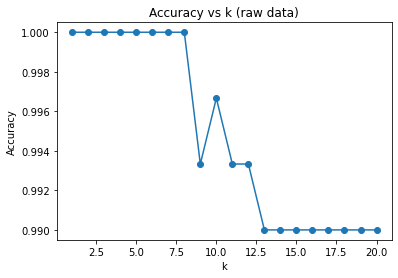

In [100]:
acc_or = test_diff_k_acc(X_train, y_train, X_val, y_val)
plt.plot(list(range(1,21)), acc_or,'-o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k (raw data)')
plt.show()

In [101]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

In [102]:
def acc_lst(cm,c):
    global_acc = np.trace(cm)/np.sum(cm)
    class_acc_lst = []
    for i in range(c):
        class_acc = cm[i,i]/np.sum(cm,axis=1)[i]
        class_acc_lst.append(class_acc)
    accuracy = [global_acc, *class_acc_lst]
    return accuracy
    
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
    
def pretty_bar(index, accuracy, title):    
    fig, ax = plt.subplots(figsize=(10, 4))
    my_cmap = plt.cm.get_cmap('GnBu')
    colors = my_cmap(accuracy)
    rects = ax.bar(index, accuracy, color=colors, width=0.5)
    addlabels(index, accuracy)
    sm = matplotlib.cm.ScalarMappable(cmap=my_cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Accuracy', rotation=270,labelpad=25)
    plt.title(title)
    plt.xticks(index)  
    plt.ylabel('Accuracy')
    return plt.show()

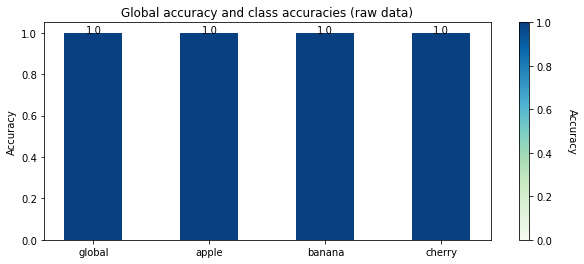

In [103]:
cm_raw = confusion_matrix(y_test, y_pred)
raw_acc = acc_lst(cm_raw, 3)
idxs = ['global', 'apple', 'banana', 'cherry']
pretty_bar(idxs, raw_acc, 'Global accuracy and class accuracies (raw data)')

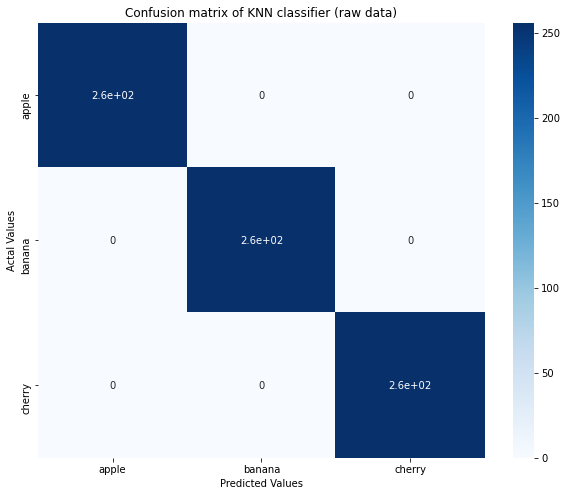

In [144]:
class_idx = ['apple', 'banana', 'cherry']
cm_raw_df = pd.DataFrame(cm_raw,
                     index = class_idx, 
                     columns = class_idx)
plt.figure(figsize=(10,8))
sns.heatmap(cm_raw_df, annot=True, cmap="Blues")
plt.title('Confusion matrix of KNN classifier (raw data)')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [148]:
precision_recall_fscore_support(y_test, y_pred)

(array([1., 1., 1.]),
 array([1., 1., 1.]),
 array([1., 1., 1.]),
 array([256, 256, 256]))

In [105]:
#concatinate three df to do pca
df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df_f = df.drop(columns=['label'])
df_l = df['label'].copy()

<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

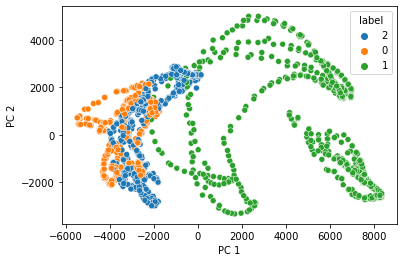

In [106]:
pca = PCA(n_components=2)
pca_2 = pca.fit_transform(df_f)
PC2_df = pd.DataFrame(data = pca_2,
                            columns = ['PC 1', 'PC 2'],
                            index = list(df_f.index)
                            )
PC2_df = pd.concat([PC2_df, df_l], axis = 1)
sns.scatterplot(data=PC2_df, x='PC 1',y='PC 2', hue="label")

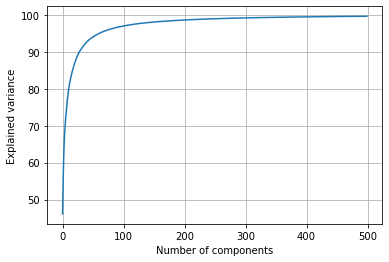

In [107]:
#cumulated sum of the variace of the eigenvectors.
pca_500 = PCA(n_components=500)
pca_500.fit(df_f)
plt.grid()
plt.plot(np.cumsum(pca_500.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

In [108]:
#dimensional reduction with PCA
pca = PCA(n_components=20)
PC_20 = pca.fit_transform(df_f)
col_names = ['PC '+str(x) for x in range(1, 21)]
PC20_df = pd.DataFrame(data = PC_20,
                              columns = col_names,
                              index = list(df_f.index)
                              )
PC20_df = pd.concat([PC20_df, df_l], axis = 1)

In [109]:
pca_train, pca_val, pca_test = PC20_df.iloc[:len(train_df)],  PC20_df.iloc[len(train_df):len(train_df)+len(val_df)],  PC20_df.iloc[len(train_df)+len(val_df):len(train_df)+len(val_df)+len(test_df)]
X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test = feature_label_split(pca_train, pca_val, pca_test)

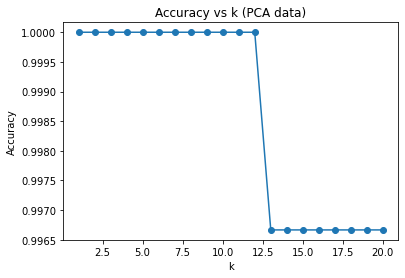

In [110]:
acc_pca = test_diff_k_acc(X_train_pca, y_train, X_val_pca, y_val)
plt.plot(list(range(1,21)), acc_pca,'-o')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title('Accuracy vs k (PCA data)')
plt.show()

In [111]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train_pca, y_train)
y_pred_pca = neigh.predict(X_test_pca)

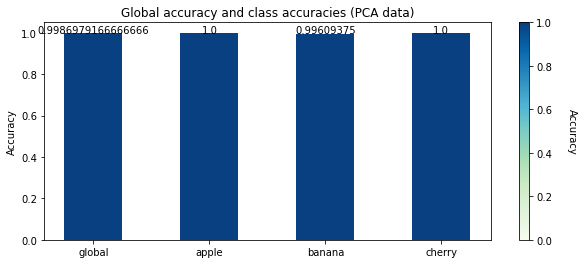

In [112]:
cm_pca = confusion_matrix(y_test, y_pred_pca)
pca_acc = acc_lst(cm_pca, 3)
pretty_bar(idxs, pca_acc, 'Global accuracy and class accuracies (PCA data)')

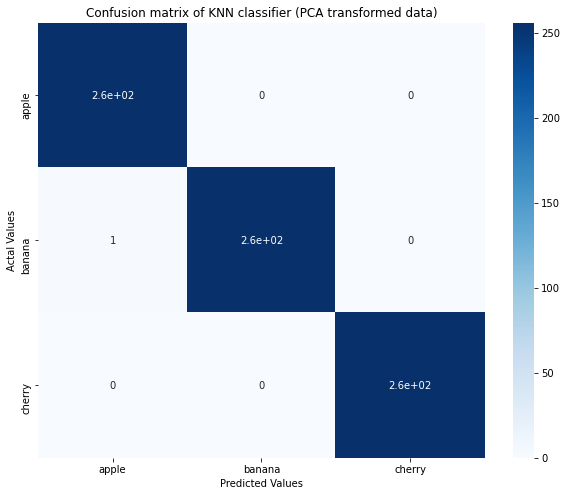

In [143]:
cm_pca_df = pd.DataFrame(cm_pca,
                     index = class_idx, 
                     columns = class_idx)
plt.figure(figsize=(10,8))
sns.heatmap(cm_pca_df, annot=True, cmap="Blues")
plt.title('Confusion matrix of KNN classifier (PCA transformed data)')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [149]:
precision_recall_fscore_support(y_test, y_pred_pca)

(array([0.99610895, 1.        , 1.        ]),
 array([1.        , 0.99609375, 1.        ]),
 array([0.99805068, 0.99804305, 1.        ]),
 array([256, 256, 256]))

<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

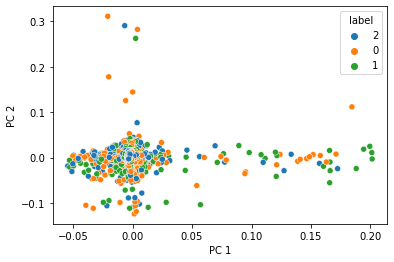

In [114]:
kpca2 = KernelPCA(kernel="rbf", 
                 fit_inverse_transform=True,
                 gamma=10,
                 n_components=2)
kpca2 = kpca2.fit_transform(df_f)
col_names = ['PC '+str(x) for x in range(1, 3)]
kpa2_df = pd.DataFrame(data = kpca2,
                              columns = col_names,
                              index = list(df_f.index)
                              )
kpa2_df = pd.concat([kpa2_df, df_l], axis = 1)
sns.scatterplot(data=kpa2_df, x='PC 1',y='PC 2', hue="label")

In [115]:
kpca20 = KernelPCA(kernel="rbf", 
                 fit_inverse_transform=True,
                 gamma=10,
                 n_components=20)
kpca20 = kpca20.fit_transform(df_f)
col_names = ['PC '+str(x) for x in range(1, 21)]
kpca20_df = pd.DataFrame(data = kpca20,
                              columns = col_names,
                              index = list(df_f.index)
                              )
kpca20_df = pd.concat([kpca20_df, df_l], axis = 1)

In [116]:
kpca_train, kpca_val, kpca_test = kpca20_df.iloc[:900],  kpca20_df.iloc[900:1200],  kpca20_df.iloc[1200:]
X_train_kpca, y_train, X_val_kpca, y_val, X_test_kpca, y_test = feature_label_split(kpca_train, kpca_val, kpca_test)

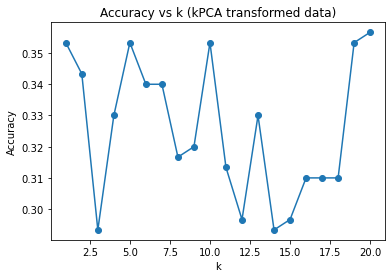

In [118]:
acc_kpca = test_diff_k_acc(X_train_kpca, y_train, X_val_kpca, y_val)
plt.plot(list(range(1,21)), acc_kpca,'-o')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title('Accuracy vs k (kPCA transformed data)')
plt.show()

In [120]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X_train_kpca, y_train)
y_pred_kpca = neigh.predict(X_test_kpca)

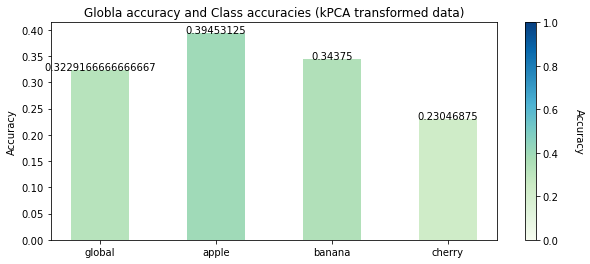

In [121]:
cm_kpca = confusion_matrix(y_test, y_pred_kpca)
kpca_acc = acc_lst(cm_kpca, 3)
pretty_bar(idxs, kpca_acc,'Globla accuracy and Class accuracies (kPCA transformed data)')

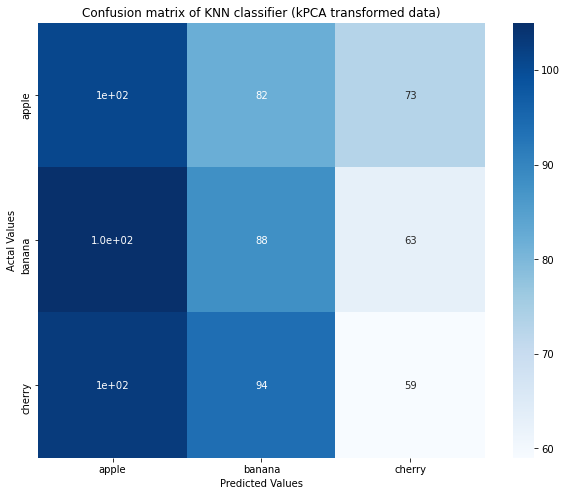

In [141]:
cm_kpca_df = pd.DataFrame(cm_kpca,
                     index = class_idx, 
                     columns = class_idx)
plt.figure(figsize=(10,8))
sns.heatmap(cm_kpca_df, annot=True, cmap="Blues")
plt.title('Confusion matrix of KNN classifier (kPCA transformed data)')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [150]:
precision_recall_fscore_support(y_test, y_pred_kpca)

(array([0.32686084, 0.33333333, 0.3025641 ]),
 array([0.39453125, 0.34375   , 0.23046875]),
 array([0.35752212, 0.33846154, 0.2616408 ]),
 array([256, 256, 256]))

In [123]:
df_arr = df_f.to_numpy()
mle = skdim.id.MLE().fit(df_arr)
print(mle.dimension_)

2.4226428691897572


In [124]:
LE = SpectralEmbedding(n_components=2)
LE2 = LE.fit_transform(df_f)
LE2_df = pd.DataFrame(data = LE2,
                             columns = ['PC 1', 'PC 2'],
                             index = list(df_f.index)
                             )
LE2_df = pd.concat([LE2_df, df_l], axis = 1)

<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

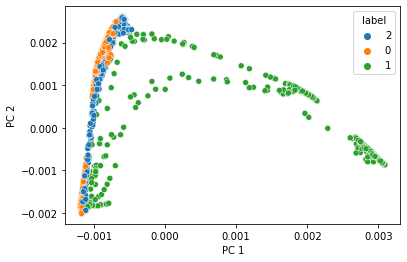

In [125]:
sns.scatterplot(data=LE2_df,x='PC 1',y='PC 2', hue="label")

In [126]:
LE_train, LE_val, LE_test = LE2_df.iloc[:900],  LE2_df.iloc[900:1200],  LE2_df.iloc[1200:]
X_train_LE, y_train, X_val_LE, y_val, X_test_LE, y_test = feature_label_split(LE_train, LE_val, LE_test)

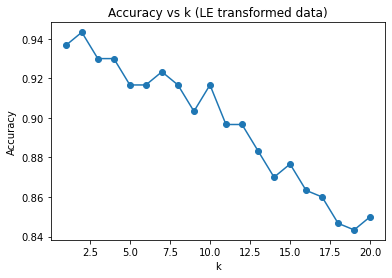

In [127]:
acc_LE = test_diff_k_acc(X_train_LE, y_train, X_val_LE, y_val)
plt.plot(list(range(1,21)), acc_LE,'-o')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title('Accuracy vs k (LE transformed data)')
plt.show()

In [133]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train_LE, y_train)
y_pred_LE = neigh.predict(X_test_LE)

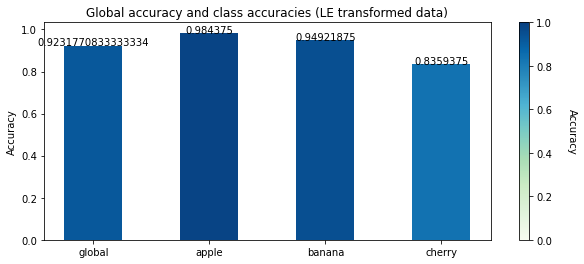

In [134]:
cm_le = confusion_matrix(y_test, y_pred_LE)
le_acc = acc_lst(cm_le, 3)
pretty_bar(idxs, le_acc,'Global accuracy and class accuracies (LE transformed data)')

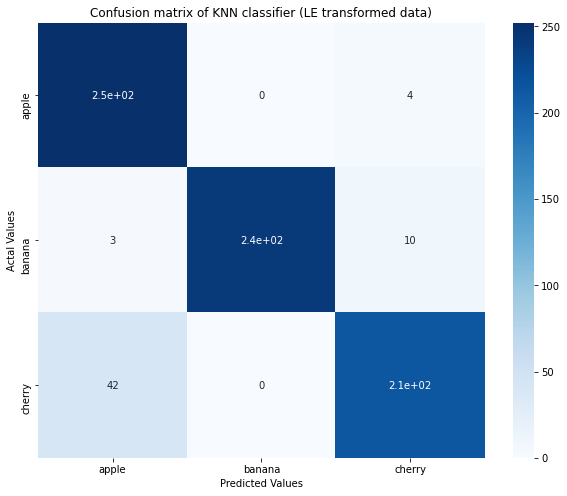

In [142]:
cm_le_df = pd.DataFrame(cm_le,
                     index = class_idx, 
                     columns = class_idx)
plt.figure(figsize=(10,8))
sns.heatmap(cm_le_df, annot=True, cmap="Blues")
plt.title('Confusion matrix of KNN classifier (LE transformed data)')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [152]:
precision_recall_fscore_support(y_test, y_pred_LE)

(array([0.84848485, 1.        , 0.93859649]),
 array([0.984375  , 0.94921875, 0.8359375 ]),
 array([0.91139241, 0.9739479 , 0.88429752]),
 array([256, 256, 256]))

In [136]:
cms = [cm_raw, cm_pca, cm_kpca, cm_le]
global_acc_lst = []
for cm in cms:
    global_acc = np.trace(cm)/np.sum(cm)
    global_acc_lst.append(global_acc)    

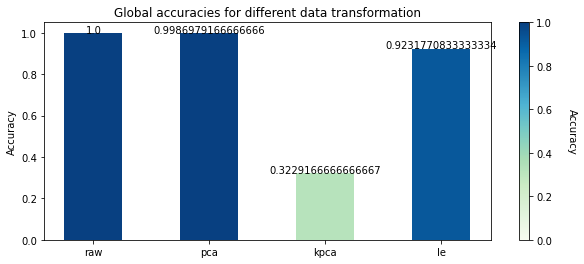

In [137]:
dmtech_lst = ['raw', 'pca', 'kpca', 'le']
pretty_bar(dmtech_lst, global_acc_lst, 'Global accuracies for different data transformation')